# Lightning Imaging Sensor (LIS) Examples

LIS is an optical instrument that measures the optical emission from lightning. It is onboard the International Space Station. The optical emission is measured by integrating the recieved light in a narrowband around 777.4 nm in ~2ms increments, which are referred to as frames. 

LIS data is arranged in parent-child hierarchy. Flashes are the top of the hierarchy; flashes are comprised of groups (so, groups are the children of flashes). (Note that groups are considered the fundamental physical measurement, roughly corresponding to return strokes.) Groups are comprised of events, which correspond to the pixels of the LIS CCD. 

Enough of the (quick) background - on to the examples!

In [1]:
# First, we'll do some basic imports we'll need here:
from pathlib import Path

# The LIS class can be done as a package level import (We'll do module level imports soon enough)
from pyltg import LIS  

import numpy as np

# imports for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# NOTE: If you're using a dark theme on Jupyter Lab, some plots
# in this notebook are not rendered correctly. The plots are fine; it's
# an issue with the dark theme.

In [2]:
# We're going to be doing some plotting, so set up some variables
map_proj = ccrs.Mercator()
ll_proj_geo = ccrs.Geodetic()
ll_proj = ccrs.PlateCarree()  
# There's a bug in cartopy 0.18 (but not 0.17) that doesn't allow you
# scatter plot using Geodetic. So, we're going to need two projections here.
# Should be fixed in 0.18.1 https://github.com/SciTools/cartopy/issues/1583

# So, why do we need Geodetic? When plotting across the 
# International Date Line, Geodetic is much better behaved. 

In [3]:
# We'll assume you have all the data files in one place:
data_path = Path('./test_files').resolve()

## Reading in the data

Let's read in the file:

In [4]:
_file = 'ISS_LIS_SC_V1.0_20201109_NQC_21887.nc'
l = LIS(data_path.joinpath(_file))
l

For the LIS class, there are four main attributes of interest, and they are all
Ltg classes:

In [5]:
l.flashes, l.groups, l.events, l.one_second

(<pyltg.core.baseclass.Ltg at 0x119da3e48>,
 <pyltg.core.baseclass.Ltg at 0x119da3f28>)

In [6]:
l.flashes.count

68

In [7]:
l.flashes.head()

,time,delta_time,observe_time,lat,lon,radiance,footprint,id,_orig_id,child_id,...,alert_flag,cluster_index,density_index,noise_index,oblong_index,glint_index,grouping_sequence,grouping_status,alt,active
0,2020-11-09 06:48:19.417195200,0.000000,101,-12.404478,-172.437057,40958.0,210.796692,0,0,0,...,2,99,54,1,0.0,0.000000,73920,0,0.0,True
1,2020-11-09 06:48:20.258808970,0.254257,101,-12.306137,-172.459106,134894.0,440.304901,1,1,1,...,2,99,65,1,0.0,0.000000,74224,0,0.0,True
2,2020-11-09 06:49:27.135762095,0.372375,101,-12.300279,-172.494415,220634.0,303.439880,2,2,4,...,2,99,65,0,0.0,-0.317236,74544,0,0.0,True
3,2020-11-09 06:49:06.003575205,0.033676,102,-10.394300,-171.053970,59314.0,161.695480,3,3,16,...,2,99,44,0,0.0,0.000000,74912,0,0.0,True
4,2020-11-09 06:49:06.373936533,0.261688,102,-10.401452,-171.059479,67496.0,172.780914,4,4,19,...,2,99,44,0,0.0,0.000000,75232,0,0.0,True


## Simple Plotting with the Field of View
First, you might want to simply plot all the flashes:

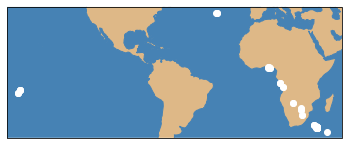

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': map_proj})

_ = ax.scatter(l.flashes.lon, l.flashes.lat, transform=ll_proj, color='white')

# Some map bling
land = ax.add_feature(cfeature.LAND, facecolor='burlywood')
ocean = ax.add_feature(cfeature.OCEAN, facecolor='steelblue')


LIS data contains information about where the satellite every ~ one second. We can use this to plot the field of view (FOV). Let's get the field of view every ~100 seconds and add it to the map:

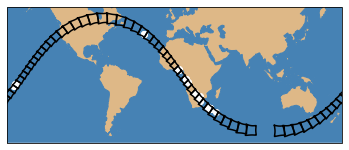

In [9]:
# First, we need to import the relevant function from the LIS module
from pyltg.core.lis import get_fov  # We'll import everything in a sec, but this shows how to get one function

# This will return a list for every FOV you want
fov = get_fov(l.one_second[0::100])

for _f in fov:
    _ = ax.plot(_f.lon, _f.lat, transform=ll_proj_geo, color='black')
    
fig  # This is an example of a funky looking plot in the dark theme

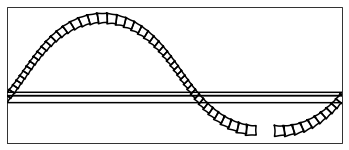

In [10]:
# As a quick aside, notice what happens when you try to use PlateCaree:
fig_bad, ax_bad = plt.subplots(subplot_kw={'projection': map_proj})

for _f in fov:
    _ = ax_bad.plot(_f.lon, _f.lat, transform=ll_proj, color='black')

## Plot Event Polygons

Let's plot the events in one of the groups in the data. By definition, the events in a group come from a single frame.

(Note this example is supposed to give you an idea how to geolocate pixels. If 
you're plotting events, use the method described in a moment...)

In [11]:
# Before we do this, there will be several functions we need. Import them all, 
# but protect the namespace:
import pyltg.core.lis as ltgLIS

In [12]:
# Pick one of the groups, by its ID.
which_group = 100
evs = l.get_events(l.groups[which_group].id, combine=True)

# By default, this function will get the corners of the footprint of 
# each event (pixel) you pass it.
lla = ltgLIS.geolocate_events_in_frame(evs, l.one_second)

# Next, we build the Polygons for each event, coloring them by radiance 
# (techincally, it's not radiance but spectral energy density), which 
# which is a measure of how "bright" the lightning is
ev_poly = ltgLIS.event_poly(evs, corners=lla, latlon=True, fill=True)

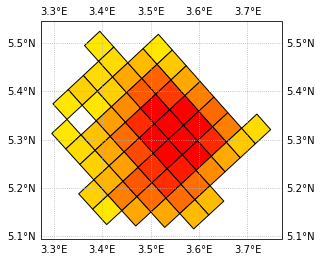

In [13]:
# Now that we have the geolocated polygons for each event, we can plot them:
map_proj = ccrs.Mercator()
ll_proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': map_proj})

ax.add_collection(ev_poly)

ax.autoscale()

gl = ax.gridlines(draw_labels=True, linestyle=':')

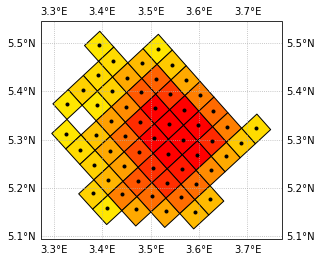

In [14]:
# Put the event centers on, but we need to increase zorder to put them
# above the event polygons
ax.scatter(evs.lon, evs.lat, transform=ll_proj, color='black', zorder=11, marker='.')

fig

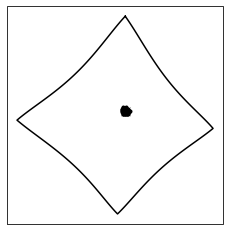

In [15]:
# Bonus: add the LIS FOV footprint for this group.

fov = ltgLIS.get_fov(l.one_second, times=evs.iloc[0].time)  # Remember, we get a list from get_fov...

# If you plot it, the map will zoom out and "squish" the events....
ax.plot(fov[0].lon, fov[0].lat, transform=ll_proj, color='black')

fig

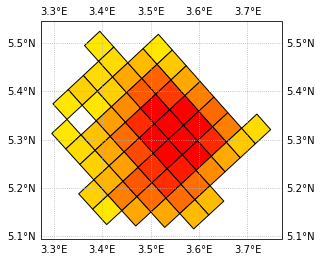

In [16]:
# Of course, if you have a particular group(s) you want to plot, you can 
# simply use the method in the LIS class:

_ = l.plot_groups(l.groups[which_group], do_events=True, fill_events=True)

## Test Geolocation

You might wonder if the fancy code does a good job of geolocating pixels. We can test that pretty easily....

In [17]:
which_group = 100  # Yep, same groups as above
evs = l.get_events(l.groups[which_group].id, combine=True)

# Again, events of a group are guaranteed to be in the same frame.
# This time, though, we don't want the footprint polygons of the pixels, 
# just the geolocated center of each pixel. 
lla = ltgLIS.geolocate_events_in_frame(evs, l.one_second, corners=False)

In [18]:
# Compare how close we are to the values embedded in the data file.
# These will be in degrees...
print((lla.lat-evs.lat).abs().max())
print((lla.lon-evs.lon).abs().max())

0.004422661369196668
0.0008072353280734745


## Plot a Background

LIS also takes a background image at a non-standard interval (but roughly every ~40 seconds). This data is contained in a different file. During the day, you can use this to "see" clouds, land, etc. in the field of view. 

In [19]:
bg_file = 'ISS_LIS_BG_V1.0_20200823_NQC_20683.nc'

# I'm assuming you've downloaded the file to same directory as the data file...
lis_bg = ltgLIS.LIS_Background(data_path.joinpath(bg_file))

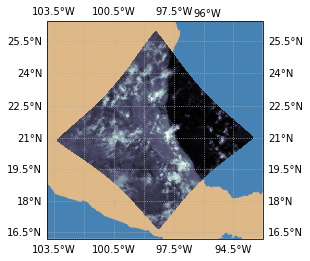

In [20]:
# Pick one of these to plot:
_ = lis_bg.plot(idx=77)

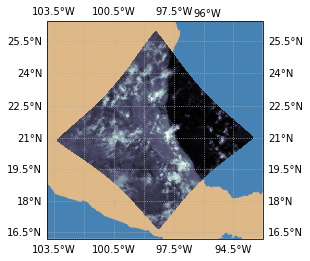

In [21]:
# Instead of specifying which background in the file you want, use the time you want.
# This will give the same plot:
_ = lis_bg.plot(time=np.datetime64('2020-08-23T20:07:30')) 

The LIS_Background class is pretty rudimentary - I call it "dirty". There's a lot of information that isn't read in from the background file. 

Let's say you want this data. You might use `xarray` to read it in. For example, 
check out Lang: https://github.com/nasa/ISS_Camera_Geolocate/blob/master/notebooks/ISS_LIS_Background_Geolocation_Demo.ipynb


In [22]:
import xarray

lisb = xarray.open_dataset(data_path.joinpath(bg_file))

lisb

<xarray.Dataset>
Dimensions:                                 (bg_info_dim: 5573, corners_dim: 8, event_count_dim: 6, latlon_dim: 2, tdim: 104, transform_matrix_dim: 9, vector_dim: 3, xdim: 128, ydim: 128)
Coordinates:
    bg_data_summary_TAI93_time              (tdim) datetime64[ns] ...
    bg_data_summary_lat                     (tdim) float32 ...
    bg_data_summary_lon                     (tdim) float32 ...
    bg_info_TAI93_time                      (bg_info_dim) datetime64[ns] ...
Dimensions without coordinates: bg_info_dim, corners_dim, event_count_dim, latlon_dim, tdim, transform_matrix_dim, vector_dim, xdim, ydim
Data variables:
    bg_data                                 (tdim, ydim, xdim) float32 ...
    bg_orbit_summary_id_number              int32 ...
    bg_orbit_summary_TAI93_start            datetime64[ns] ...
    bg_orbit_summary_UTC_start              object ...
    bg_orbit_summary_GPS_start              timedelta64[ns] ...
    bg_orbit_summary_TAI93_end              datetime64[ns] ...
    bg_orbit_summary_start_longitude        float32 ...
    bg_orbit_summary_end_longitude          float32 ...
    bg_orbit_summary_image_summary_count    int16 ...
    bg_orbit_summary_image_summary_address  int16 ...
    bg_orbit_summary_image_info_count       int16 ...
    bg_orbit_summary_image_info_address     int16 ...
    bg_data_summary_address                 (tdim) float64 ...
    bg_data_summary_boresight               (tdim, latlon_dim) float32 ...
    bg_data_summary_corners                 (tdim, corners_dim) float32 ...
    bg_info_alert_summary                   (bg_info_dim) uint8 ...
    bg_info_instrument_alert                (bg_info_dim) uint8 ...
    bg_info_platform_alert                  (bg_info_dim) uint8 ...
    bg_info_external_alert                  (bg_info_dim) uint8 ...
    bg_info_processing_alert                (bg_info_dim) uint8 ...
    bg_info_position_vector                 (bg_info_dim, vector_dim) float32 ...
    bg_info_velocity_vector                 (bg_info_dim, vector_dim) float32 ...
    bg_info_transform_matrix                (bg_info_dim, transform_matrix_dim) float32 ...
    bg_info_solar_vector                    (bg_info_dim, vector_dim) float32 ...
    bg_info_ephemeris_quality_flag          (bg_info_dim) int32 ...
    bg_info_attitude_quality_flag           (bg_info_dim) int32 ...
    bg_info_bg_value                        (bg_info_dim) int16 ...
    bg_info_noise_index                     (bg_info_dim) int8 ...
    bg_info_event_count                     (bg_info_dim, event_count_dim) int16 ...
Attributes:
    history:      This LIS background product in netCDF4/HDF5 format is conve...
    Conventions:  CF-1.6

Most of the code necessary to do the plotting is available in functions (i.e., they're not tied to a class). So, you can do a lot of the same things, albeit with 
a little more code gymnastics. As an example how to use these, let's take
the variables read in from xarray...

In [23]:
# First, we need to get the spacecraft location at the time of the background image.
# This is not usually "on" one of the one seconds, so we do a simple (linear) 
# interpolation to find the relevant spacecraft attributes:

which_bkgnd = 77 # index of background you want - this will be over Mexico

pos, vel, xform_matrix = ltgLIS.interp_one_sec(lisb.bg_data_summary_TAI93_time.data[which_bkgnd],
                                        one_sec_times = lisb.bg_info_TAI93_time.data,
                                        one_sec_pos = lisb.bg_info_position_vector,
                                        one_sec_vel = lisb.bg_info_velocity_vector,
                                        one_sec_transform_matrix = lisb.bg_info_transform_matrix)

There are three attributes that describe where the spacecraft is that are needed for geolocation: the position, the velocity, and the tranform matrix. That's what we get.

In [24]:
# Next, we need to get pixel addresses for the entire CCD, and geolocate all of them:

ccd = ltgLIS.ccd_pixels(full_frame=True)

lla = ltgLIS.geolocate_pixels(pos, vel, xform_matrix, ccd.x, ccd.y)

# Note: This is somewhat similar to geolocating events. The function here is for locating pixels (by x,y address), 
# while the function we used earlier is for events from a data file.

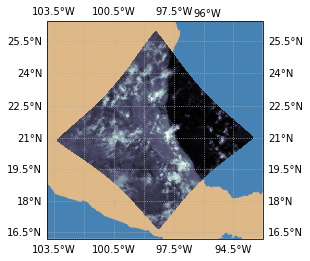

In [25]:
# Now, we plot:

fig, ax = plt.subplots(subplot_kw={'projection': map_proj})

ax.pcolormesh(lla.lon.reshape(128, 128), lla.lat.reshape(128, 128),
              lisb.bg_data[which_bkgnd].T, transform=ll_proj, alpha=0.8, cmap='bone')

land = ax.add_feature(cfeature.LAND, facecolor='burlywood')
ocean = ax.add_feature(cfeature.OCEAN, facecolor='steelblue')

gl=ax.gridlines(draw_labels=True, linestyle=':')

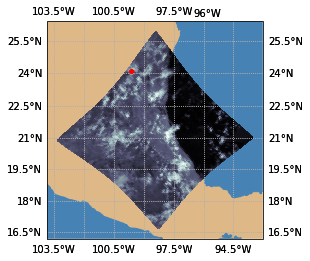

In [26]:
# For fun, let's put some lightning on top the background

# Get the data file
_file = 'ISS_LIS_SC_V1.0_20200823_FIN_20683.nc'

l2 = ltgLIS.LIS(data_path.joinpath(_file))

t0 = np.datetime64('2020-08-23T20:07:30', 'ns')
t1 = np.datetime64('2020-08-23T20:07:31', 'ns')

# Plot the background
ax = lis_bg.plot(time=t0) # Remember that this gets the closest background image!

# Find the groups in this time period:
cnt = l2.groups.limit(time=[t0, t1])  # Note that the times need to be np.datetime64[ns] (or int64)
# When we call limit, the data that do not satisfy the limits are marked "inactive"

_, lis_grp_plt = l2.plot_groups(ax=ax, group_color='red')  # Only active groups get plotted


## Comparison with GLM

Now, let's do some comparisons with GLM...

In [27]:
from pyltg import GLM

_file = 'OR_GLM-L2-LCFA_G16_s20202362007200_e20202362007400_c20202362007426.nc'

g = GLM(data_path.joinpath(_file))

In [28]:
# Find all the GLM groups detected during this time:

cnt = g.groups.limit(time=[t0, t1])  # Limit the "active" groups to this time


In [29]:
# This only limits in time. LIS will only see a subset of the GLM field of view, so
# let's find which of these groups are also in the LIS field of view.

# To do this, we need to get the LIS field of view!
fov = ltgLIS.get_fov(l2.one_second, times=t0)

fov = fov[0]  # We don't need it as a list here....

# Now, we'll use a MPL Path to find which of the groups are also in the field of view:
import matplotlib.path as mplPath

hull_path = mplPath.Path(list(zip(fov.lon, fov.lat)))

in_fov = hull_path.contains_points(list(zip(g.groups.lon, g.groups.lat)))

# Now, use this to update the "active" data:
cnt = g.groups.limit(active=in_fov)


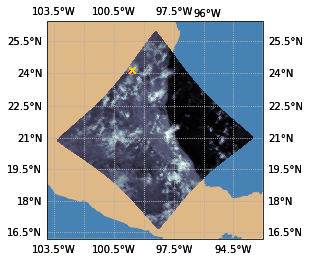

In [30]:
# Now, plot these! (Note that we already have gridlines, so we don't plot them again)
_, glm_grp_plt = g.plot_groups(ax=ax, group_color='gold', gridlines=False, group_marker='x')
ax.figure # Another plot that doesn't look good under Jupyter lab dark mode...

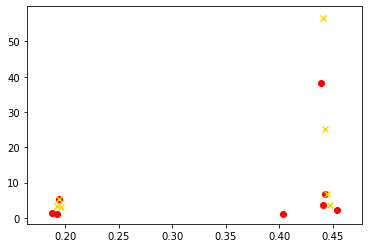

In [31]:
# Now, let's look at the time series of groups from each instrument. 

# But since it will be a short time period, we'll want to do some time manipulation first.

_glm_t = (g.groups.time.astype('int64') - t0.astype('int64'))/1e9
_lis_t = (l2.groups.time.astype('int64') - t0.astype('int64'))/1e9

# While there's a way to "convert" the LIS radiance to something analagous to GLM energy, 
# here, we'll just normalize them to visualize:
fig, ax = plt.subplots() 
_ = ax.scatter(_lis_t, l2.groups.radiance/5000, color='red')
_ = ax.scatter(_glm_t, g.groups.energy/1e-15, color='gold', marker='x')


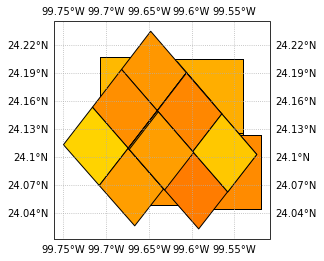

In [32]:
# So, LIS detects the flash first (not surprising given GLM ground processing constaints).

# Now, let's look at the flash varies spatially, remembering the plotting of
# GLM events is approximate.

ax, glm_plot_elements = g.plot_groups(do_events=True)
_, lis_plot_elements = l2.plot_groups(do_events=True, ax=ax, gridlines=False)
ax.autoscale() # On some machines I need this, others not - this will show all of the polygons


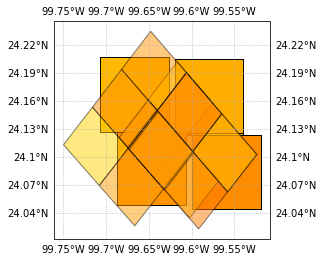

In [33]:
# There is a difference (for now) how the event polygons are returned
# in the LIS and GLM classes. The GLM class return the polygons as one
# MPL PolyCollection, while for LIS class returns a list. 

# Given this, let's change the transparency (alpha) for the LIS groups:

for poly in lis_plot_elements['events_poly']:
    poly.set_alpha(0.5)
ax.figure

# Among other things, you can see the event footprint(s) move during this time 
# (since LIS is moving).

In [34]:
# If you want to inspect the "active" data, we've got a method for that:
g.groups.get_active()

# (Keep in mind the index displayed in the Dataframe is relative to _all_ the data!)

,time,lat,lon,energy,id,_orig_id,parent_id,area,quality_flag,alt,child_count,active
2239,2020-08-23 20:07:30.192647933,24.163982,-99.579987,3.284790e-15,2239,1849656186,193,72.028084,0.0,0.0,1,True
2240,2020-08-23 20:07:30.194555282,24.164005,-99.579994,5.284550e-15,2240,1849656189,193,72.028084,0.0,0.0,1,True
2241,2020-08-23 20:07:30.196462631,24.164030,-99.580009,3.184802e-15,2241,1849656193,193,72.028084,0.0,0.0,1,True
2242,2020-08-23 20:07:30.440988540,24.143641,-99.597206,5.657839e-14,2242,1849656252,193,288.264923,0.0,0.0,4,True
2243,2020-08-23 20:07:30.442895889,24.145363,-99.585503,2.528215e-14,2243,1849656253,193,216.236832,0.0,0.0,3,True
2244,2020-08-23 20:07:30.444803237,24.164099,-99.579979,6.884358e-15,2244,1849656254,193,72.028084,0.0,0.0,1,True
2245,2020-08-23 20:07:30.447092056,24.164106,-99.579971,3.484766e-15,2245,1849656255,193,72.028084,0.0,0.0,1,True


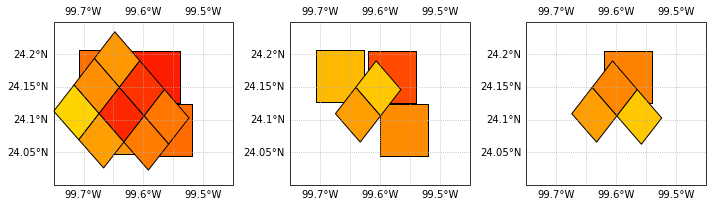

In [35]:
# There are groups from both instruments in three consecutive frames starting around 20:07:30.439.
# Remember the _precision_ (not the accuracy) of LIS/GLM timing is around 2ms, so these don't line up exactly. 
# Let's look at them:

glm_grp_idx = 3, 4, 5  # These are found by inspection and are the "locations" in the active data
lis_grp_idx = 4, 5, 6

bounds = [-99.75, -99.45, 24, 24.25]  # pick some bounds for plotting, so all the plot extents are the same

fig, ax = plt.subplots(subplot_kw={'projection': map_proj}, ncols=3, figsize=(12, 3)) 

for idx in np.arange(3):
    
    ax[idx].set_extent(bounds, ll_proj)
    
    # Here, we don't plot all the active groups, so we pass in the group we
    # to plot and each step of the loop:
    _, glm_grp_plt = g.plot_groups(g.groups[glm_grp_idx[idx]], do_events=True, ax=ax[idx])
    
    _ = l2.plot_groups(l2.groups[lis_grp_idx[idx]], do_events=True, ax=ax[idx], gridlines=False)
    
    glm_grp_plt['gridlines'].right_labels = False  # Make things a little prettier


In [36]:
# As an aside, the method get_active returns a copy of the active data, so you can manipulate to
# your heart's content. 

# For instance, to see how we found the idx's above you could do this:

glm_grps = g.groups.get_active()
glm_grps.reset_index(inplace=True)
glm_grps

,index,time,lat,lon,energy,id,_orig_id,parent_id,area,quality_flag,alt,child_count,active
0,2239,2020-08-23 20:07:30.192647933,24.163982,-99.579987,3.284790e-15,2239,1849656186,193,72.028084,0.0,0.0,1,True
1,2240,2020-08-23 20:07:30.194555282,24.164005,-99.579994,5.284550e-15,2240,1849656189,193,72.028084,0.0,0.0,1,True
2,2241,2020-08-23 20:07:30.196462631,24.164030,-99.580009,3.184802e-15,2241,1849656193,193,72.028084,0.0,0.0,1,True
3,2242,2020-08-23 20:07:30.440988540,24.143641,-99.597206,5.657839e-14,2242,1849656252,193,288.264923,0.0,0.0,4,True
4,2243,2020-08-23 20:07:30.442895889,24.145363,-99.585503,2.528215e-14,2243,1849656253,193,216.236832,0.0,0.0,3,True
5,2244,2020-08-23 20:07:30.444803237,24.164099,-99.579979,6.884358e-15,2244,1849656254,193,72.028084,0.0,0.0,1,True
6,2245,2020-08-23 20:07:30.447092056,24.164106,-99.579971,3.484766e-15,2245,1849656255,193,72.028084,0.0,0.0,1,True


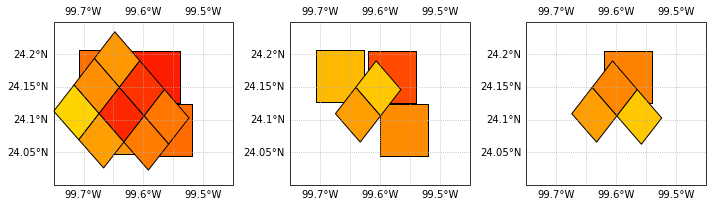

In [37]:
# How about another aside?

# You can go get things by their "locations" realtive to all the data, (i.e., not just active). 
# But this takes a bit more Pandas gymnastics.

glm_grp_idx = 2242, 2243, 2244  # locations relative to all the data
lis_grp_idx = 1808, 1809, 1810

bounds = [-99.75, -99.45, 24, 24.25]  # pick some bounds, so all the plot extents are the same

fig, ax = plt.subplots(subplot_kw={'projection': map_proj}, ncols=3, figsize=(12, 3))

for idx in np.arange(3):
    ax[idx].set_extent(bounds, ll_proj)
    
    # The gynamsicts entails, basically, using loc. Remember, g.groups.data gets you all the data!
    _, glm_grp_plt = g.plot_groups(g.groups.data.loc[glm_grp_idx[idx]], do_events=True, ax=ax[idx])
    
    _ = l2.plot_groups(l2.groups.data.loc[lis_grp_idx[idx]], do_events=True, ax=ax[idx], gridlines=False)
    
    glm_grp_plt['gridlines'].right_labels = False  #
